In [1]:
# Load libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2_contingency

In [2]:
# Read data and write onto dataframe
species = pd.read_csv("species_info.csv")
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [3]:
# Find size of dataframe
species.shape

(5824, 4)

In [4]:
obs = pd.read_csv("observations.csv")
obs.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [5]:
obs.shape

(23296, 3)

In [6]:
# Explore data - what types of species are listed?
print(species.category.unique())

['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [7]:
# How much data do we have for the different types of species?
species.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

In [8]:
# Explore data - how many different species are listed?
print(species.scientific_name.nunique())

5541


In [9]:
# What does conservation_status mean? What are the types?
print(species.conservation_status.unique())

[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [10]:
# Chance NaN values to 'No Concern'
species = species.fillna('No Concern')

In [11]:
# How much data do we have for the different types of conservation status?
species.groupby("conservation_status").size()

conservation_status
Endangered              16
In Recovery              4
No Concern            5633
Species of Concern     161
Threatened              10
dtype: int64

In [12]:
# Explore data - what National Parks are listed?
print(obs.park_name.unique())

['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


In [13]:
# How much data do we have for the different National Parks?
obs.groupby("park_name").size()

park_name
Bryce National Park                    5824
Great Smoky Mountains National Park    5824
Yellowstone National Park              5824
Yosemite National Park                 5824
dtype: int64

In [14]:
# How many total observations of wildlife have been recorded?
obs.observations.sum()

3314739

In [15]:
# Order the classes based on relative biological evolution
order_class = ['Nonvascular Plant', 'Vascular Plant', 'Fish', 'Amphibian', 'Reptile', 'Bird', 'Mammal']
species['category'] = species['category'].astype(CategoricalDtype(categories=order_class, ordered=True))

# Order the status by least severe to most severe
order_status = ['Species of Concern', 'Threatened', 'Endangered', 'In Recovery']
species['conservation_status'] = species['conservation_status'].astype(CategoricalDtype(categories=order_status, ordered=True))

# New datafrmae listing only species with significant conservation status and group by class
statusbyClass = species[species.conservation_status != "No Concern"]\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

statusbyClass

category,Nonvascular Plant,Vascular Plant,Fish,Amphibian,Reptile,Bird,Mammal
conservation_status,,,,,,,
Species of Concern,5,43,4,4,5,72,28
Threatened,0,2,4,2,0,0,2
Endangered,0,1,3,1,0,4,7
In Recovery,0,0,0,0,0,3,1


Text(0, 0.5, 'Number of Species')

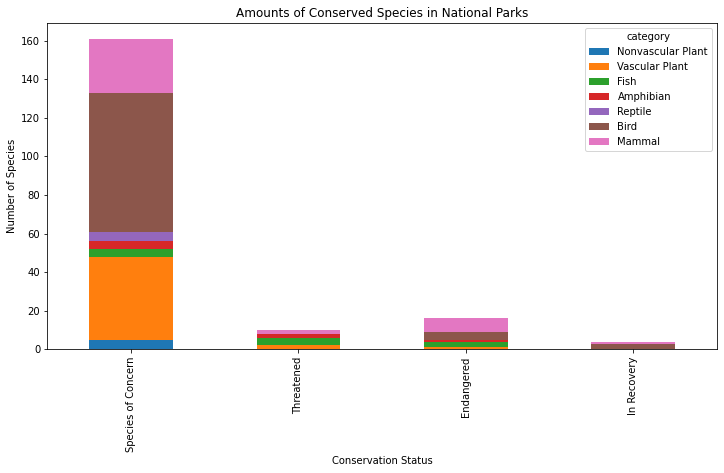

In [16]:
ax = statusbyClass.plot(kind = 'bar', figsize=(12,6), stacked=True)
ax.set_title('Amounts of Conserved Species in National Parks')
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species")

In [17]:
# Reorder status including No Concern
order_status = ['No Concern', 'Species of Concern', 'Threatened', 'Endangered', 'In Recovery']
species['conservation_status'] = species['conservation_status'].astype(CategoricalDtype(categories=order_status, ordered=True))

# Create new boolean column indicating if species is protected or not
species['is_protected'] = species.conservation_status != 'No Concern'

In [18]:
# Create dataframe showing counts of protected vs non-protected ordered by class
class_counts = species.groupby(['category', 'is_protected'])\
                        .scientific_name.nunique()\
                        .reset_index()\
                        .pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
class_counts.columns = ['class', 'not_protected', 'protected']

class_counts

,class,not_protected,protected
0,Nonvascular Plant,328,5
1,Vascular Plant,4216,46
2,Fish,115,11
3,Amphibian,72,7
4,Reptile,73,5
5,Bird,413,75
6,Mammal,146,30


In [19]:
# Create new column showing percent of the class protected
class_counts['percent_protected'] = class_counts.protected / (class_counts.protected + class_counts.not_protected) * 100

class_counts

,class,not_protected,protected,percent_protected
0,Nonvascular Plant,328,5,1.501502
1,Vascular Plant,4216,46,1.079305
2,Fish,115,11,8.730159
3,Amphibian,72,7,8.860759
4,Reptile,73,5,6.410256
5,Bird,413,75,15.368852
6,Mammal,146,30,17.045455


Text(0, 0.5, '% Protected')

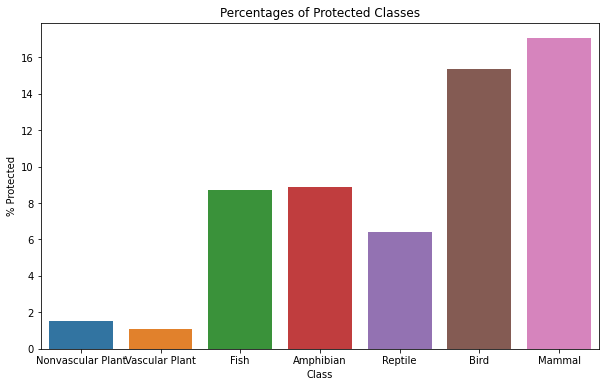

In [20]:
# Creat bar chart showing percentages of classes protected
plt.figure(figsize=(10,6))
sns.barplot(y="percent_protected", x="class", data=class_counts)
plt.title('Percentages of Protected Classes')
plt.xlabel('Class')
plt.ylabel("% Protected")

In [21]:
# Set up a contingency table to run a chi-squared test on Mammals and a Birds
# The table looks like this:
#           PROTECTED    NOT-PROTECTED
#    MAMMAL       30              146
#    BIRD         75              413

contingency1 = [[30, 146],[75, 413]]
chi_test_MB = chi2_contingency(contingency1)
print(chi_test_MB)
print('p-value is {}'.format(chi_test_MB[1]))

(0.1617014831654557, 0.6875948096661336, 1, array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]]))
p-value is 0.6875948096661336


In [22]:
# The second value in the result is the p-value.
# p-values < 0.05 show that there is a statstical significance signifiance between the two variables
# Becuase the p-value between protection status of mammals and birds is 0.69, 
  # there is no significant relationship between thenm (the variables are independent)

In [23]:
# Set up a contingency table to run a chi-squared test on Mammals and a Reptiles
contingency2 = [[30, 146],[5, 73]]
chi_test_MR = chi2_contingency(contingency2)
print('p-value is {}'.format(chi_test_MR[1]))

p-value is 0.03835559022969898


In [24]:
# The p-value is < 0.05, so it shows that the difference between Mammals and Reptiles is statistically significant.
# Mammals are shown to have a statistically significant higher rate of needed protection compared with Reptiles.

In [25]:
print(species['common_names'].head())
# The data in the common_names column is messy - multiple values, punctuation, unnecesary data

# Clean up data to
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

common_Names[:6]

0                             Gapper's Red-Backed Vole
1                                American Bison, Bison
2    Aurochs, Aurochs, Domestic Cattle (Feral), Dom...
3    Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)
4                                        Wapiti Or Elk
Name: common_names, dtype: object


[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [26]:
# Remove duplicate words
cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
cleanRows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [27]:
# Collapse words into one list
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
res[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

In [28]:
# Count occurences of each word
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(20)

,Word,Count
83,Bat,23
59,Shrew,18
66,Myotis,17
108,Mouse,16
17,Chipmunk,13
203,Squirrel,12
77,American,12
38,Vole,11
70,Eastern,11
121,Western,10


In [29]:
# Create a new column indicating if a species is a bat
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)

# Show the data frame containing only bats
species[species.is_bat]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,NaN,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",NaN,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,NaN,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,NaN,False,True


In [30]:
# Merge dataframes to observe what National Parks these bats appear
bats = obs.merge(species[species.is_bat])
bats

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,NaN,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


In [31]:
# Observe counts of bats at different National Parks
bats.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


In [32]:
# Observe counts of bats at different National Parks and whether or not they are protected
bats_by_park = bats.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
bats_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


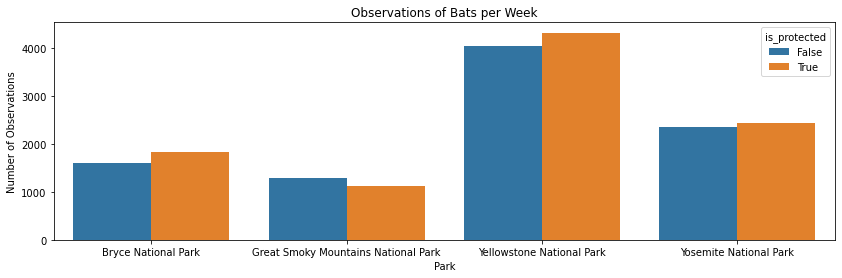

In [33]:
# Create bar chart to show bat observations
plt.figure(figsize=(14, 4))
sns.barplot(x=bats_by_park.park_name, y= bats_by_park.observations, hue=bats_by_park.is_protected)
plt.xlabel('Park')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats per Week')
plt.show()

In [34]:
# Create a new column indicating if a species is a chipmunk
species['is_chipmunk'] = species.common_names.str.contains(r"\bChipmunk\b", regex = True)

# Show the data frame containing only chipmunks
species[species.is_chipmunk]



,category,scientific_name,common_names,conservation_status,is_protected,is_bat,is_chipmunk
77,Mammal,Tamias striatus,Eastern Chipmunk,NaN,False,False,True
3063,Mammal,Neotamias amoenus,Yellow Pine Chipmunk,NaN,False,False,True
3064,Mammal,Neotamias minimus,Least Chipmunk,NaN,False,False,True
3065,Mammal,Neotamias umbrinus,Uinta Chipmunk,NaN,False,False,True
3068,Mammal,Tamias amoenus,Yellow-Pine Chipmunk,NaN,False,False,True
3069,Mammal,Tamias minimus,Least Chipmunk,NaN,False,False,True
3070,Mammal,Tamias umbrinus,Uinta Chipmunk,NaN,False,False,True
4491,Mammal,Tamias alpinus,Alpine Chipmunk,NaN,False,False,True
4492,Mammal,Tamias merriami,Merriam's Chipmunk,NaN,False,False,True
4493,Mammal,Tamias quadrimaculatus,Long-Eared Chipmunk,NaN,False,False,True


In [35]:
# Merge dataframes to observe what National Parks these Chipmunks appear
chipmunks = obs.merge(species[species.is_chipmunk])
chipmunks

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat,is_chipmunk
0,Tamias quadrimaculatus,Yellowstone National Park,261,Mammal,Long-Eared Chipmunk,NaN,False,False,True
1,Tamias quadrimaculatus,Yosemite National Park,168,Mammal,Long-Eared Chipmunk,NaN,False,False,True
2,Tamias quadrimaculatus,Bryce National Park,95,Mammal,Long-Eared Chipmunk,NaN,False,False,True
3,Tamias quadrimaculatus,Great Smoky Mountains National Park,62,Mammal,Long-Eared Chipmunk,NaN,False,False,True
4,Tamias umbrinus,Great Smoky Mountains National Park,87,Mammal,Uinta Chipmunk,NaN,False,False,True
5,Tamias umbrinus,Great Smoky Mountains National Park,87,Mammal,Inyo Chipmunk,NaN,False,False,True
6,Tamias umbrinus,Great Smoky Mountains National Park,85,Mammal,Uinta Chipmunk,NaN,False,False,True
7,Tamias umbrinus,Great Smoky Mountains National Park,85,Mammal,Inyo Chipmunk,NaN,False,False,True
8,Tamias umbrinus,Yosemite National Park,182,Mammal,Uinta Chipmunk,NaN,False,False,True
9,Tamias umbrinus,Yosemite National Park,182,Mammal,Inyo Chipmunk,NaN,False,False,True


In [36]:
# Observe counts of chipmunks at different National Parks
chipmunks_by_park = chipmunks.groupby(['park_name']).observations.sum().reset_index()
chipmunks_by_park['Mammal'] = 'Chipmunk'
chipmunks_by_park

,park_name,observations,Mammal
0,Bryce National Park,1607,Chipmunk
1,Great Smoky Mountains National Park,1168,Chipmunk
2,Yellowstone National Park,3659,Chipmunk
3,Yosemite National Park,2355,Chipmunk


In [37]:
# Create a new column indicating if a species is a Mouse
species['is_mouse'] = species.common_names.str.contains(r"\bMouse\b", regex = True)


# Show the data frame containing only Mice, filter out non-mammals that contain the name 'Mouse'
species[(species['is_mouse']) & (species['category'] == 'Mammal')]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat,is_chipmunk,is_mouse
56,Mammal,Ochrotomys nuttalli,Golden Mouse,NaN,False,False,False,True
60,Mammal,Peromyscus gossypinus,Cotton Mouse,NaN,False,False,False,True
61,Mammal,Peromyscus leucopus,White-Footed Mouse,NaN,False,False,False,True
62,Mammal,Peromyscus maniculatus,Deer Mouse,NaN,False,False,False,True
63,Mammal,Reithrodontomys humulis,Eastern Harvest Mouse,NaN,False,False,False,True
66,Mammal,Napaeozapus insignis,Woodland Jumping Mouse,NaN,False,False,False,True
67,Mammal,Zapus hudsonius,Meadow Jumping Mouse,NaN,False,False,False,True
69,Mammal,Mus musculus,House Mouse,NaN,False,False,False,True
3057,Mammal,Peromyscus maniculatus,"Deer Mouse, North American Deermouse",NaN,False,False,False,True
3059,Mammal,Zapus princeps,Western Jumping Mouse,NaN,False,False,False,True


In [38]:
# Merge dataframes to observe what National Parks these Mice appear
mice = obs.merge(species[(species['is_mouse']) & (species['category'] == 'Mammal')])
mice

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat,is_chipmunk,is_mouse
0,Peromyscus truei,Yosemite National Park,126,Mammal,"Pi_On Deermouse, Pi_On Mouse, Pinyon Mouse",NaN,False,False,False,True
1,Peromyscus truei,Great Smoky Mountains National Park,85,Mammal,"Pi_On Deermouse, Pi_On Mouse, Pinyon Mouse",NaN,False,False,False,True
2,Peromyscus truei,Bryce National Park,83,Mammal,"Pi_On Deermouse, Pi_On Mouse, Pinyon Mouse",NaN,False,False,False,True
3,Peromyscus truei,Yellowstone National Park,291,Mammal,"Pi_On Deermouse, Pi_On Mouse, Pinyon Mouse",NaN,False,False,False,True
4,Peromyscus californicus,Yellowstone National Park,276,Mammal,California Mouse,NaN,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
67,Chaetodipus californicus,Bryce National Park,130,Mammal,California Pocket Mouse,NaN,False,False,False,True
68,Napaeozapus insignis,Bryce National Park,130,Mammal,Woodland Jumping Mouse,NaN,False,False,False,True
69,Napaeozapus insignis,Great Smoky Mountains National Park,74,Mammal,Woodland Jumping Mouse,NaN,False,False,False,True
70,Napaeozapus insignis,Yellowstone National Park,252,Mammal,Woodland Jumping Mouse,NaN,False,False,False,True


In [39]:
# Observe counts of mice at different National Parks
mice_by_park = mice.groupby(['park_name']).observations.sum().reset_index()
mice_by_park['Mammal'] = 'Mouse'
mice_by_park

,park_name,observations,Mammal
0,Bryce National Park,1735,Mouse
1,Great Smoky Mountains National Park,1162,Mouse
2,Yellowstone National Park,4508,Mouse
3,Yosemite National Park,2541,Mouse


In [40]:
# Create a new column indicating if a species is a Squirrel
species['is_squirrel'] = species.common_names.str.contains(r"\bSquirrel\b", regex = True)

# Show the data frame containing only Mice, filter out non-mammals that contain the name 'Squirrel'
species[(species['is_squirrel']) & (species['category'] == 'Mammal')]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat,is_chipmunk,is_mouse,is_squirrel
72,Mammal,Glaucomys sabrinus coloratus,"Carolina Northern Flying Squirrel, Northern Fl...",Endangered,True,False,False,False,True
73,Mammal,Glaucomys volans,Southern Flying Squirrel,NaN,False,False,False,False,True
75,Mammal,Sciurus carolinensis,"Eastern Gray Squirrel, Gray Squirrel",NaN,False,False,False,False,True
76,Mammal,Sciurus niger,"Eastern Fox Squirrel, Fox Squirrel",NaN,False,False,False,False,True
78,Mammal,Tamiasciurus hudsonicus,Red Squirrel,NaN,False,False,False,False,True
3061,Mammal,Glaucomys sabrinus,Northern Flying Squirrel,NaN,False,False,False,False,True
3066,Mammal,Spermophilus armatus,Uinta Ground Squirrel,NaN,False,False,False,False,True
3067,Mammal,Spermophilus lateralis,Golden-Mantled Ground Squirrel,NaN,False,False,False,False,True
4488,Mammal,Callospermophilus lateralis,Golden-Mantled Ground Squirrel,NaN,False,False,False,False,True
4489,Mammal,Otospermophilus beecheyi,California Ground Squirrel,NaN,False,False,False,False,True


In [41]:
# Merge dataframes to observe what National Parks these Squirrels appear
squirrels = obs.merge(species[(species['is_squirrel']) & (species['category'] == 'Mammal')])
squirrels

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat,is_chipmunk,is_mouse,is_squirrel
0,Urocitellus beldingi,Yosemite National Park,157,Mammal,Belding's Ground Squirrel,NaN,False,False,False,False,True
1,Urocitellus beldingi,Bryce National Park,131,Mammal,Belding's Ground Squirrel,NaN,False,False,False,False,True
2,Urocitellus beldingi,Yellowstone National Park,244,Mammal,Belding's Ground Squirrel,NaN,False,False,False,False,True
3,Urocitellus beldingi,Great Smoky Mountains National Park,112,Mammal,Belding's Ground Squirrel,NaN,False,False,False,False,True
4,Callospermophilus lateralis,Great Smoky Mountains National Park,84,Mammal,Golden-Mantled Ground Squirrel,NaN,False,False,False,False,True
5,Callospermophilus lateralis,Yosemite National Park,121,Mammal,Golden-Mantled Ground Squirrel,NaN,False,False,False,False,True
6,Callospermophilus lateralis,Bryce National Park,97,Mammal,Golden-Mantled Ground Squirrel,NaN,False,False,False,False,True
7,Callospermophilus lateralis,Yellowstone National Park,250,Mammal,Golden-Mantled Ground Squirrel,NaN,False,False,False,False,True
8,Spermophilus armatus,Yosemite National Park,123,Mammal,Uinta Ground Squirrel,NaN,False,False,False,False,True
9,Spermophilus armatus,Bryce National Park,106,Mammal,Uinta Ground Squirrel,NaN,False,False,False,False,True


In [42]:
# Observe counts of squirrel at different National Parks
squirrels_by_park = squirrels.groupby(['park_name']).observations.sum().reset_index()
squirrels_by_park['Mammal'] = 'Squirrel'
squirrels_by_park

,park_name,observations,Mammal
0,Bryce National Park,1064,Squirrel
1,Great Smoky Mountains National Park,864,Squirrel
2,Yellowstone National Park,2857,Squirrel
3,Yosemite National Park,1524,Squirrel


In [43]:
# Create a new column indicating if a species is a Fox
species['is_fox'] = species.common_names.str.contains(r"\bFox\b", regex = True)

# Show the data frame containing only Mice, filter ourt non-mammals that contain the name 'Fox'
species[(species['is_fox']) & (species['category'] == 'Mammal')]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat,is_chipmunk,is_mouse,is_squirrel,is_fox
10,Mammal,Urocyon cinereoargenteus,"Common Gray Fox, Gray Fox",NaN,False,False,False,False,False,True
11,Mammal,Vulpes fulva,"Black Fox, Cross Fox, Red Fox, Silver Fox",NaN,False,False,False,False,False,True
12,Mammal,Vulpes vulpes,Red Fox,NaN,False,False,False,False,False,True
76,Mammal,Sciurus niger,"Eastern Fox Squirrel, Fox Squirrel",NaN,False,False,False,False,True,True
4449,Mammal,Urocyon cinereoargenteus,Gray Fox,NaN,False,False,False,False,False,True
4450,Mammal,Vulpes vulpes necator,Sierra Nevada Red Fox,NaN,False,False,False,False,False,True


In [44]:
# Merge dataframes to observe what National Parks these Squirrels appear
foxes = obs.merge(species[(species['is_fox']) & (species['category'] == 'Mammal')])
foxes

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat,is_chipmunk,is_mouse,is_squirrel,is_fox
0,Vulpes fulva,Great Smoky Mountains National Park,66,Mammal,"Black Fox, Cross Fox, Red Fox, Silver Fox",NaN,False,False,False,False,False,True
1,Vulpes fulva,Yosemite National Park,133,Mammal,"Black Fox, Cross Fox, Red Fox, Silver Fox",NaN,False,False,False,False,False,True
2,Vulpes fulva,Bryce National Park,114,Mammal,"Black Fox, Cross Fox, Red Fox, Silver Fox",NaN,False,False,False,False,False,True
3,Vulpes fulva,Yellowstone National Park,227,Mammal,"Black Fox, Cross Fox, Red Fox, Silver Fox",NaN,False,False,False,False,False,True
4,Vulpes vulpes necator,Bryce National Park,109,Mammal,Sierra Nevada Red Fox,NaN,False,False,False,False,False,True
5,Vulpes vulpes necator,Great Smoky Mountains National Park,70,Mammal,Sierra Nevada Red Fox,NaN,False,False,False,False,False,True
6,Vulpes vulpes necator,Yellowstone National Park,294,Mammal,Sierra Nevada Red Fox,NaN,False,False,False,False,False,True
7,Vulpes vulpes necator,Yosemite National Park,155,Mammal,Sierra Nevada Red Fox,NaN,False,False,False,False,False,True
8,Urocyon cinereoargenteus,Great Smoky Mountains National Park,91,Mammal,"Common Gray Fox, Gray Fox",NaN,False,False,False,False,False,True
9,Urocyon cinereoargenteus,Great Smoky Mountains National Park,91,Mammal,Gray Fox,NaN,False,False,False,False,False,True


In [45]:
# Observe counts of foxes at different National Parks
foxes_by_park = foxes.groupby(['park_name']).observations.sum().reset_index()
foxes_by_park['Mammal'] = 'Fox'
foxes_by_park

,park_name,observations,Mammal
0,Bryce National Park,893,Fox
1,Great Smoky Mountains National Park,630,Fox
2,Yellowstone National Park,1941,Fox
3,Yosemite National Park,1224,Fox


In [50]:
ground_mammals = (foxes_by_park
    .merge(mice_by_park, how='outer')
    .merge(squirrels_by_park, how='outer')
    .merge(chipmunks_by_park, how='outer')
)

ground_mammals

,park_name,observations,Mammal
0,Bryce National Park,893,Fox
1,Great Smoky Mountains National Park,630,Fox
2,Yellowstone National Park,1941,Fox
3,Yosemite National Park,1224,Fox
4,Bryce National Park,1735,Mouse
5,Great Smoky Mountains National Park,1162,Mouse
6,Yellowstone National Park,4508,Mouse
7,Yosemite National Park,2541,Mouse
8,Bryce National Park,1064,Squirrel
9,Great Smoky Mountains National Park,864,Squirrel


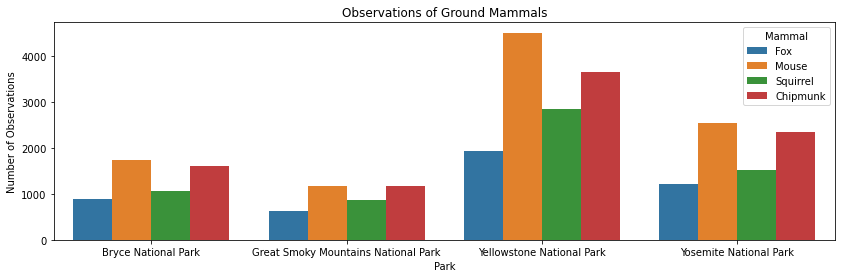

In [52]:
# Create bar chart to show ground mammal observations
plt.figure(figsize=(14, 4))
sns.barplot(x=ground_mammals.park_name, y= ground_mammals.observations, hue=ground_mammals.Mammal)
plt.xlabel('Park')
plt.ylabel('Number of Observations')
plt.title('Observations of Ground Mammals')
plt.show()